# Descarga de dataset

In [1]:
# Seleccionar el API Token personal previamente descargado (fichero kaggle.json)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"enriqueguz1701","key":"7849cc978b31b3d3352bf37ecaffd791"}'}

In [2]:
# Creamos un directorio en el que copiamos el fichero kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!(kaggle datasets list -s sprites)

ref                                                              title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ebrahimelgazar/pixel-art                                         Pixel Art                                          86MB  2024-02-10 12:17:36           1285         30  1.0              
thecaptian/pokemon-sprites                                       Pokemon Sprites                                   288MB  2022-05-23 12:48:12             66          2  0.6875           
csalexi/animal-crossing-sprites                                  Animal Crossing Villager Sprites                  514MB  2022-02-11 04:08:17             25          8  0.5              
bhavyadhingra00020/complete-pokemon-dataset-9th-gen-img-tabular  

In [4]:
!kaggle datasets download -d ebrahimelgazar/pixel-art

Dataset URL: https://www.kaggle.com/datasets/ebrahimelgazar/pixel-art
License(s): apache-2.0
100% 85.7M/85.7M [00:05<00:00, 24.0MB/s]
100% 85.7M/85.7M [00:05<00:00, 15.9MB/s]


In [5]:
# Creemos un directorio para descomprimir los datos
!mkdir sprites

In [6]:
# Descomprimimos los datos y los dejamos listos para trabajar
%%capture
!unzip pixel-art.zip -d sprites

In [7]:
!ls sprites

images	labels.csv  sprites_labels.npy	sprites.npy


# Imports

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import os
import random
import keras
from keras import layers
from keras import ops
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

# from vae import VAE
from vae_v2 import VAE, Sampling

In [32]:
input_dim = (16,16,3) # El tamaño de entrada será 16x16 porque es el tamaño de las imágenes y 3, porque tiene 3 canales
encoder_conv_filters = [32,64,64,64]
encoder_conv_kernel_size = [3,3,3,3]
encoder_conv_strides = [2,2,2,2]
decoder_conv_t_filters = [64,64,32,3]
decoder_conv_t_kernel_size = [3,3,3,3]
decoder_conv_t_strides = [2,1,1,1]

# Tamaño del espacio latente
z_dim = 200
lr = 0.0005
batch_size = 64
epochs = 500
r_loss_factor = 0.4
is_training = True

mu = 0
log_var = 0

In [11]:
# Cargar las imágenes desde sprites.npy
images = np.load('sprites/sprites.npy')

# Crear carpeta de destino si no existe
output_folder = 'sprites/sprites_png'
os.makedirs(output_folder, exist_ok=True)

# Guardar cada imagen
for i, img_array in enumerate(images):
    # Verifica si img_array tiene rango [-1, 1] o [0, 1] y normaliza a [0, 255]
    if img_array.min() < 0:  # Caso normalizado [-1, 1]
        img_array = ((img_array + 1) * 127.5).astype('uint8')
    elif img_array.max() <= 1:  # Caso normalizado [0, 1]
        img_array = (img_array * 255).astype('uint8')
    else:  # Si ya está en [0, 255]
        img_array = img_array.astype('uint8')

    # Convierte de RGB a BGR antes de guardar con OpenCV
    img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)

    # Guardar la imagen
    output_path = os.path.join(output_folder, f'image_{i}.png')
    cv2.imwrite(output_path, img_bgr)

print(f'Todas las imágenes se guardaron en la carpeta: {output_folder}')

Todas las imágenes se guardaron en la carpeta: sprites/sprites_png


In [10]:
def load_images(path, width, height):
    images = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.JPEG')):
                path_image = os.path.join(root, file)
                images.append(path_image)

    df = pd.DataFrame(images, columns=['File'])

    images = []
    labels = []

    for path in df['File']:
        image = cv2.imread(path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (width, height))
            image = image/255.0
            # imagen = np.expand_dims(imagen, axis=-1)
            images.append(image)
            labels.append(image)
        else:
            print(f"La imagen en {path} no se pudo cargar.")
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Sprites

In [33]:
images, _ = load_images('sprites/sprites_png/', 16, 16)


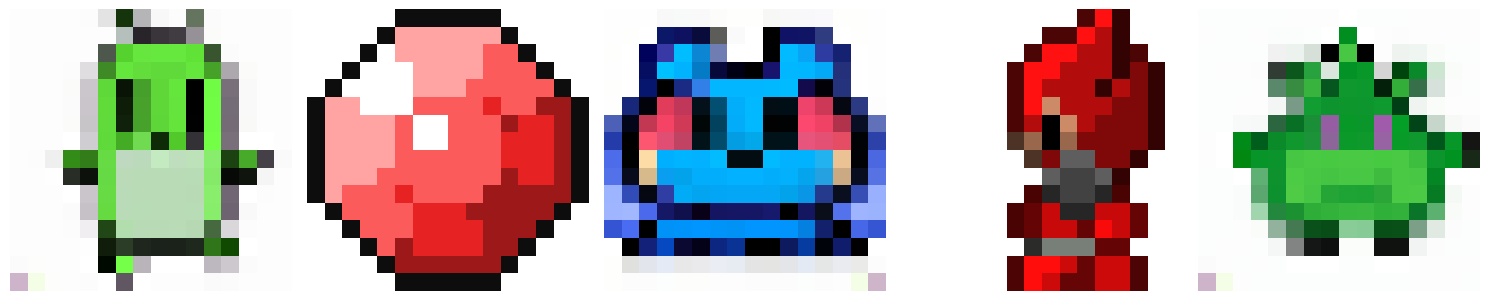

In [34]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for clase, ax in enumerate(axes):
    # Selecciona un índice aleatorio para la clase
    # indice_aleatorio = random.choice(indices_por_clase[clase])
    imagen_para_mostrar = (images[clase])  # Reescala para mostrar
    ax.imshow(imagen_para_mostrar)
    ax.axis('off')
    # ax.set_title(f"Clase: {clase}")  # Muestra el número de la clase como título

# Ajusta el layout y muestra las imágenes
plt.tight_layout()
plt.show()


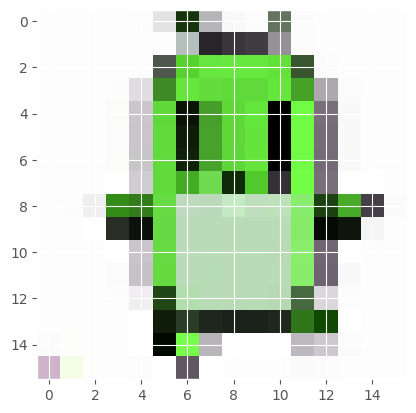

In [35]:
# Para comprobar que se han cargado bien se mostrará una imagen al azar
index = random.randint(1, len(images))
plt.imshow(images[0])
plt.show()

# VAE

In [36]:
use_batch_norm = True
use_dropout = False
encoder_input = keras.Input(shape=input_dim, name='encoder_input')
x = encoder_input

for i in range(len(encoder_conv_filters)):
    conv_layer = layers.Conv2D(filters=encoder_conv_filters[i],
                        kernel_size = encoder_conv_kernel_size[i],
                        strides = encoder_conv_strides[i],
                        padding='same',
                        name='encoder_conv'+str(i))

x = conv_layer(x)

if use_batch_norm:
    x = layers.BatchNormalization()(x)

x = layers.LeakyReLU(alpha=0.2)(x)
if use_dropout:
    x = layers.Dropout(0.25)(x)

shape_before_flattening = K.int_shape(x)[1:]
x = layers.Flatten()(x)
encoder_output = layers.Dense(z_dim, name='encoder_output')(x)

mu = layers.Dense(z_dim, name='mu')(x)
log_var = layers.Dense(z_dim, name='log_var')(x)
# def sampling(args):
#     mu, log_var = args
#     epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
#     return mu + K.exp(log_var/2)*epsilon
# encoder_output = Lambda(sampling, name='encoder_output')([self.mu, self.log_var])

# self.encoder = Model(encoder_input, encoder_output)

z = Sampling()([mu, log_var])
encoder = keras.Model(encoder_input, [mu, log_var, z], name='encoder')
encoder.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 16, 16, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv3 (Conv2D)    │ (None, 8, 8, 64)       │          1,792 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 8, 8, 64)       │            256 │ encoder_conv3[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 8, 8, 64)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 4096)           │              0 │ leaky_re_lu_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mu (Dense)                │ (None, 200)            │        819,400 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ log_var (Dense)           │ (None, 200)            │        819,400 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_1 (Sampling)     │ (None, 200)            │              0 │ mu[0][0],              │
│                           │                        │                │ log_var[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,640,848 (6.26 MB)

 Trainable params: 1,640,720 (6.26 MB)

 Non-trainable params: 128 (512.00 B)

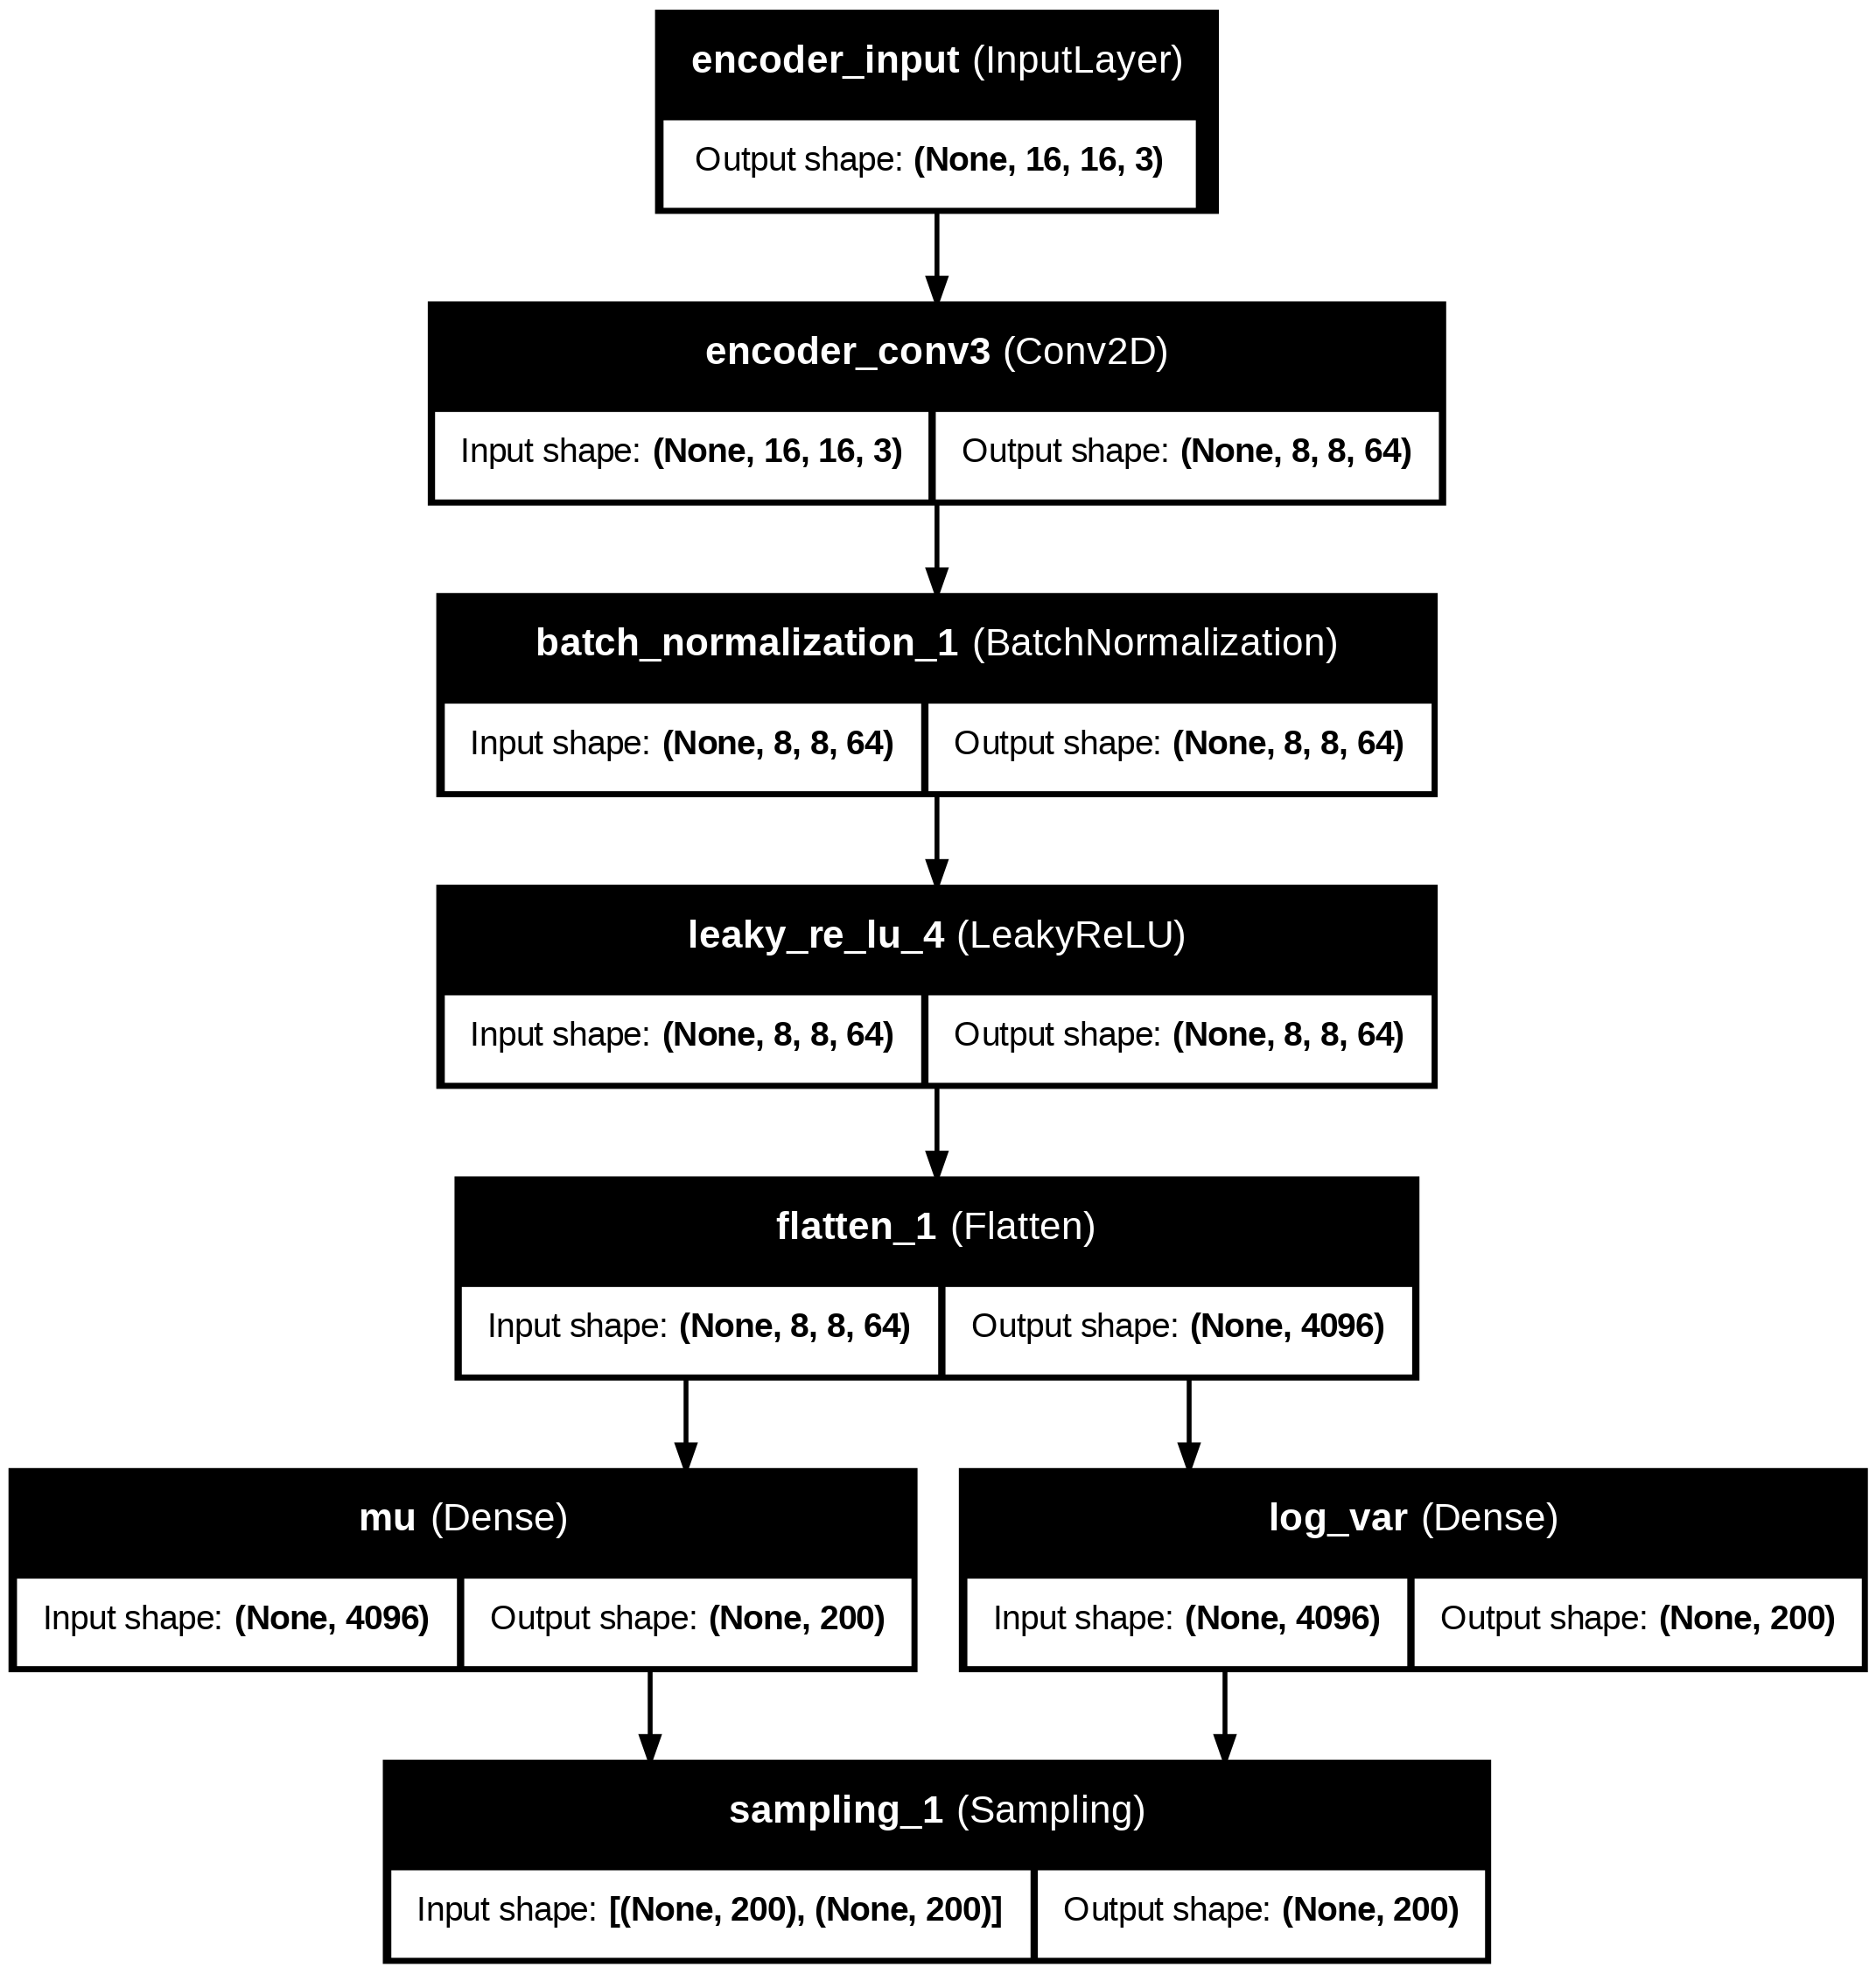

In [37]:
from tensorflow.keras.utils import plot_model

plot_model(encoder, show_shapes=True, show_layer_names=True)

In [38]:
decoder_input = keras.Input(shape=(z_dim,), name='decoder_input')

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)

for i in range(len(decoder_conv_t_filters)):
    conv_t_layer = layers.Conv2DTranspose(filters=decoder_conv_t_filters[i],
                                kernel_size = decoder_conv_t_kernel_size[i],
                                strides = decoder_conv_t_strides[i],
                                padding = 'same',
                                name = 'decoder_conv_t'+str(i))
    x = conv_t_layer(x)

    if i<len(decoder_conv_t_filters)-1:
        x = layers.LeakyReLU(alpha=0.2)(x)
    else:
        x = layers.Activation('sigmoid')(x)

decoder_output = x

decoder = keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │         823,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_t0 (Conv2DTranspose)    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_t1 (Conv2DTranspose)    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_t2 (Conv2DTranspose)    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_t3 (Conv2DTranspose)    │ (None, 16, 16, 3)           │             867 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 16, 16, 3)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 916,483 (3.50 MB)

 Trainable params: 916,483 (3.50 MB)

 Non-trainable params: 0 (0.00 B)

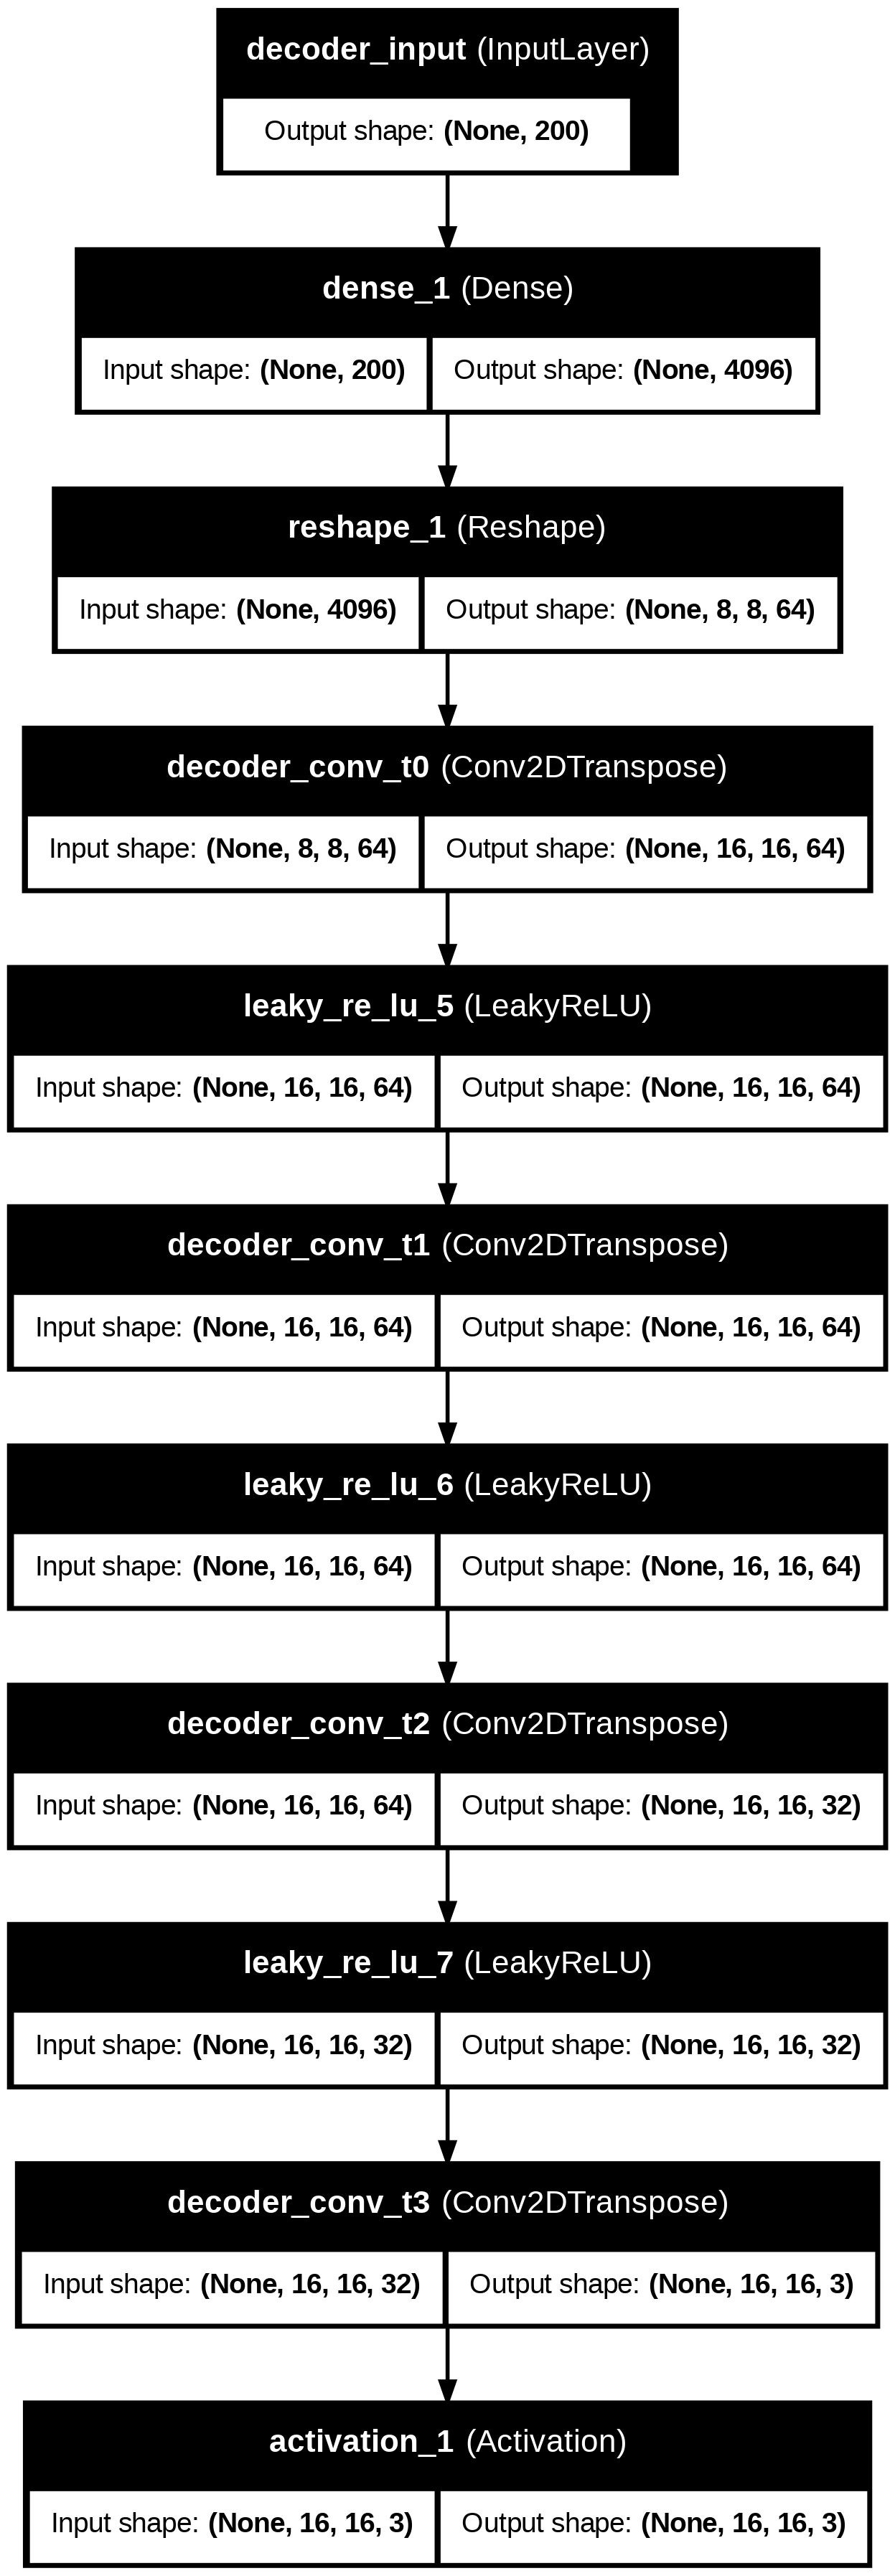

In [39]:
plot_model(decoder, show_shapes=True, show_layer_names=True)

In [40]:
vae = VAE(encoder, decoder)
epochs = 500
vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:

H = vae.fit(images, epochs=epochs, batch_size=batch_size)

Epoch 1/500
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - kl_loss: 10.9248 - loss: 116.3133 - reconstruction_loss: 0.0000e+00
Epoch 2/500
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - kl_loss: 15.8219 - loss: 89.2440 - reconstruction_loss: 0.0000e+00
Epoch 3/500
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - kl_loss: 15.3753 - loss: 84.4209 - reconstruction_loss: 0.0000e+00
Epoch 4/500
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - kl_loss: 15.1173 - loss: 82.0825 - reconstruction_loss: 0.0000e+00
Epoch 5/500
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - kl_loss: 14.9383 - loss: 80.5533 - reconstruction_loss: 0.0000e+00
Epoch 6/500
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - kl_loss: 14.8182 - loss: 79.3080 - reconstruction_loss: 0.0000e+00
Epoch 7/500
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - kl_loss: 14.7118 - loss: 78.2525 - reconstruction_loss: 0.0000e+00
Epoch 8/500
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - kl_loss: 14.6411 - loss: 77.6200 - reconstruction_loss: 0.0000e+00
Epoch 

In [ ]:
def generar_datos(vae, dimensiones_latentes, n_muestras=1):
    # Muestrea puntos aleatorios en el espacio latente
    latent_points = np.random.normal(size=(n_muestras, dimensiones_latentes))
    return vae.decoder.predict(latent_points)

# Función para mostrar varias imágenes en un grid
def mostrar_imagenes(imagenes, filas=2, columnas=5):
    fig, axes = plt.subplots(filas, columnas, figsize=(columnas * 2, filas * 2))
    for i, ax in enumerate(axes.flat):
        if i < len(imagenes):
            ax.imshow(imagenes[i], cmap='gray' if imagenes[i].shape[-1] == 1 else None)
            ax.axis('off')
    plt.tight_layout()
    plt.show()



In [ ]:
imagenes_generadas = generar_datos(vae, z_dim, 10)

mostrar_imagenes(imagenes_generadas, filas=2, columnas=5)

In [ ]:
imagenes_generadas = generar_datos(vae, z_dim, 10)

mostrar_imagenes(imagenes_generadas, filas=2, columnas=5)

In [ ]:
imagenes_generadas = generar_datos(vae, z_dim, 10)

mostrar_imagenes(imagenes_generadas, filas=2, columnas=5)